In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pydicom
from pydicom.data import get_testdata_file
import plotly.graph_objects as go

from skimage import data
from skimage.transform import radon,iradon,resize
from skimage.util import random_noise


In [3]:
# Функция возращает значения mu(x,y) выбранной функции mu, для которой известно аналитическое решение p(ksi,theta)
def mu_func(x,y):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name

    if func_name == 0: #кольцо
        r2 = (x- x0_func)**2+(y-y0_func)**2
        return A_func*r2*np.exp(-r2/a_func**2)

    if func_name == 2: # точка
        return A_func*np.exp(-((x-x0_func)**2 + (y-y0_func)**2)/a_func**2)

    if func_name == 3: # диск
        ro = np.sqrt((x - x0_func)**2 + (y - y0_func)**2)
        if a_func - ro >=0.:
            return A_func
        else:
            return 0.
        
    if func_name == 4: # вогнутый парабаллоид с четкими границами
        ro = np.sqrt((x - x0_func)**2 + (y - y0_func)**2)
        if a_func - ro >=0.:
            return A_func*ro**2
        else:
            return 0.

# Функция формирует массив mu заданного размера по известной аналитической функции
def mu_func_array():
    global N_xy
    mu = np.zeros((N_xy,N_xy))
    for int_x in range(N_xy):
        for int_y in range(N_xy):
            mu[int_x, int_y] = mu_func(int_to_xy(int_x),int_to_xy(int_y))

    return mu

# Функция возращает значения p(ksi,theta) выбранной функции p, для которой известно аналитическое решение mu(x,y)
def p_func(ksi, theta):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name
    ksi_ = ksi - x0_func*np.cos(theta) - y0_func*np.sin(theta)
    if func_name == 0:
        if ksi_ == 0:
            return 0.8862269254527578
        return np.sqrt(np.pi)*A_func*a_func*ksi_**2*np.exp(-ksi_**2/a_func**2)*(a_func**2/2/ksi_**2+1)
    if func_name == 2:
        return np.sqrt(np.pi)*A_func*a_func*np.exp(-ksi_**2/a_func**2)

    if func_name == 3:
        if a_func >= np.abs(ksi_):
            return 2*A_func*np.abs(ksi_)*np.sqrt((a_func/ksi_)**2-1)
        else:
            return 0.
        
    if func_name == 4: # эта функция пока не решена аналитически
        if a_func >= np.abs(ksi_):
            return 2*A_func*np.abs(ksi_)*np.sqrt((a_func/ksi_)**2-1)
        else:
            return 0.


# Функция формирует массив p заданного размера по известной аналитической функции
def p_func_array():
    global N_angels
    global N_rays
    p = np.zeros((N_rays,N_angels))
    for int_theta in range(N_angels):
        for int_ksi in range(N_rays):
            p[int_ksi, int_theta] = p_func(int_to_ksi(int_ksi),int_to_theta(int_theta))

    return p

In [4]:
# Набор функций для перевода значений переменных из реальных значений в индексы и обратно
def theta_to_int(theta):
    global N_angels
    return int(theta/2/np.pi*N_angels)

def ksi_to_int(ksi):
    global xy_max
    global rays_d
    return int((ksi + np.sqrt(2)*xy_max)/rays_d)

def xy_to_int(xy):
    global N_xy
    global xy_max
    return int((xy + xy_max)/2/xy_max*N_xy)

def int_to_theta(i):
    global N_angels
    return i*2.*np.pi/N_angels

def int_to_ksi(i):
    global xy_max
    global rays_d
    return i*rays_d - np.sqrt(2)*xy_max

def int_to_xy(i):
    global N_xy
    global xy_max
    return 2*xy_max/N_xy*i - xy_max

In [5]:
# Функция по заданному лучу возвращает точки пересечения луча с сеткой
def ray_tracing(theta, x, y):
    global N_xy

    q = np.zeros(3)           # используется только внутри цикла, не трогать
    qmin = np.zeros(3) - 1.  # наименьшие координаты в сетке
    qmax = np.zeros(3) + N_xy + 1 # наибольшие координаты в сетке
    dq = np.ones(3)           # шаг сетки
    rho = np.zeros(3)

    q0 = np.array([xy_to_int(x), xy_to_int(y), 0.]) # координата начала луча
    pq = np.array([-np.sin(theta), np.cos(theta), 0]) # направление движения луча
    pq = pq + 1e-9
    pq = pq / np.sqrt((pq**2).sum())

    # initial conditions
    q = q0
    b = (np.sign(pq) + 1)
    points = []
    ppqq = pq*1e-3
    while (qmin < q).all() and (q < qmax).all():
        qq = q + 1e-9*np.sign(q)
        iq = ((qq - qmin) / dq).astype(np.int32)
        a = iq*dq - (qq-qmin)
        rho = a + b*dq/2 + (1 - np.sign(a)**2)
        dt = np.abs(rho / pq).min()
        # rho = np.sqrt(np.abs(a*(a-b*dq) + b*dq2/2)).min()
        points.append(q.copy())
        q += (pq+ppqq)*dt
    _ = pd.DataFrame(points, columns=['x','y', 'z'])
    return np.array([_['x'].values, _['y'].values])





# Функция определяет координату входа луча в изображение
def ray_origin_coordinates(theta, ksi):
    global xy_max
    # по сути нам нужно найти пересечение линии ksi = x*cos(theta) + y*sin(theta) и границы снимка,
    # чтобы начать отслеживать луч именно от нее и избежать лишних вычислений

    x_line = xy_max*np.sign(np.sin(theta)) 
    y_line = -xy_max*np.sign(np.cos(theta))
    if not x_line: x_line = -xy_max
    # Эта запись позволяет определить, с какими из границ снимка нужно искать пересечение луча
    # это зависит исключительно от угла падения луча
    # в случае theta = 0, pi/2 и т.д. будет деление на бесконечность. Код отрабатывает корректно, но лучше что-то с этим сделать

    y = y_line
    x = (ksi-y*np.sin(theta))/np.cos(theta)
    if -xy_max <= x <= xy_max: # ищем пересечение с одной границей, если пересечение вне области определения, то проверяем следующую границу
        return x, y
    
    x = x_line
    y = (ksi-x*np.cos(theta))/np.sin(theta)
    if -xy_max <= y <= xy_max: #Если пересечения нет и здесь, тогда возвращаем nan, чтобы показать, что луч не задевает изображение и можно не производить лишних вычислений
        return x, y
    return np.nan, np.nan


# Функция считает итеграл 1.7 по заданным точкам пересечения луча с сеткой
def ray_projection(points, mu):
    x = points[0,:]
    y = points[1,:]
    d_dzeta = np.sqrt(np.power(x[1:]-x[:-1], 2) + np.power(y[1:]-y[:-1], 2)) # длина отрезка с постоянным mu

    # определение точек, в которых следует взять значение mu для интеграла
    # По сути это координаты клетки в которую попадает отрезок постоянного mu
    # не обязательно использовать среднее арифметическое, просто это очень удобно
    ix = ((x[1:]+x[:-1])/2).astype(np.int32)
    iy = ((y[1:]+y[:-1])/2).astype(np.int32)
    
    correct_index = (ix<N_xy)&(iy<N_xy)# это костыль для работы рей трейсинга, который выдает точки пересечения вне снимка на +-1
    ix = ix[correct_index] # значения с слишком большими индексами вырезаются
    iy = iy[correct_index]
    d_dzeta = d_dzeta[correct_index]

    return (mu[ix,iy]*d_dzeta).sum()# итеграл 1.7 


def ForwarTask(mu):
    global N_xy
    global N_rays
    global N_angels
    p = np.zeros((N_rays,N_angels))
    # цикл, перебирающий лучи со всеми theta и ksi
    for int_theta in range(N_angels):
        for int_ksi in range(N_rays):
            x, y = ray_origin_coordinates(int_to_theta(int_theta), int_to_ksi(int_ksi)) # Определение координаты пересечения луча и снимка
            if x != x: #проверка на наличие пересечения
              pass
            else:
                net_points = ray_tracing(int_to_theta(int_theta), x, y) # Определение точек пересечения луча с сеткой mu 
                p[int_ksi,int_theta] = ray_projection(net_points, mu) # Расчет проекции луча
    return p

C:\Temp\ipykernel_12948\952853064.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  y = (ksi-x*np.cos(theta))/np.sin(theta)


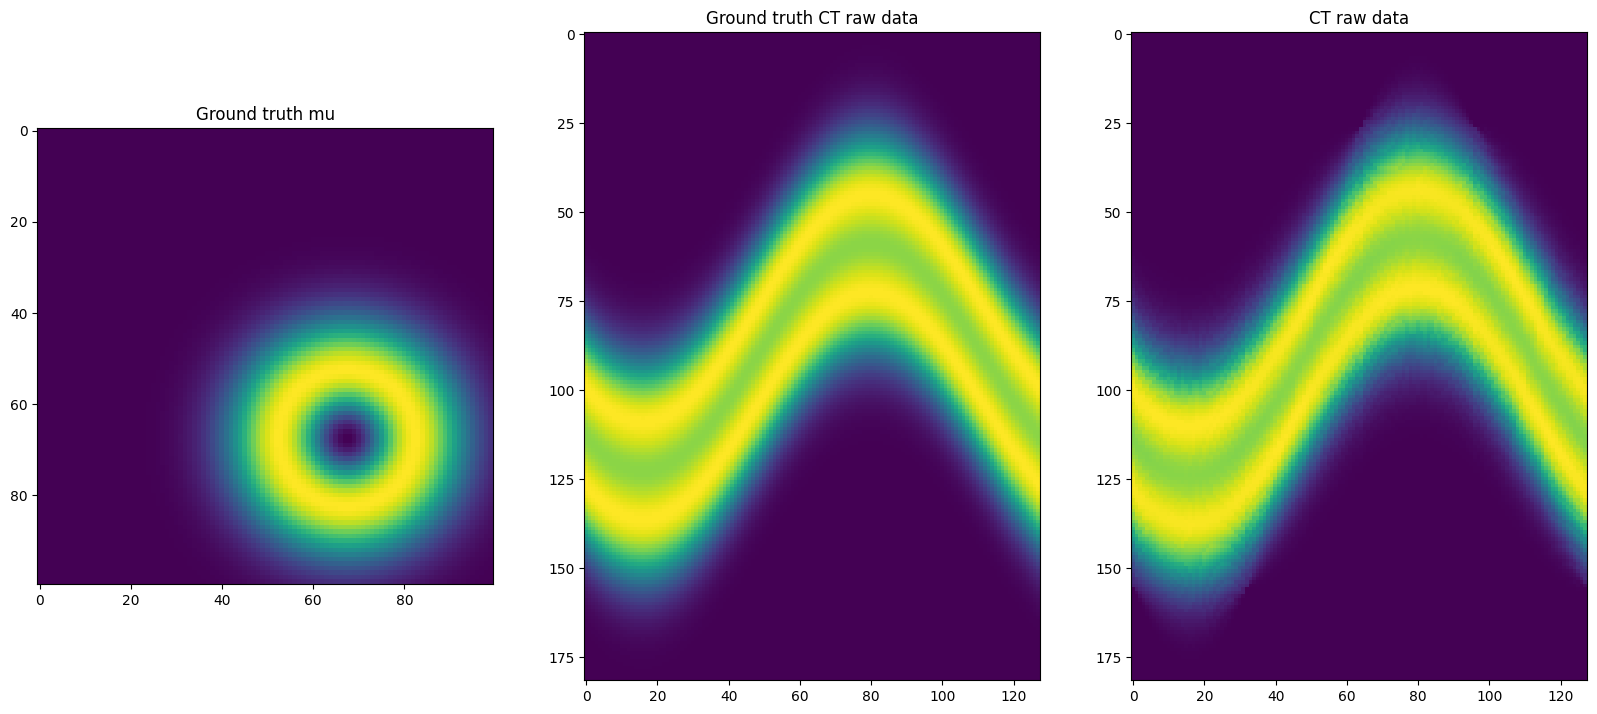

<Figure size 2000x200 with 0 Axes>

In [6]:
N_angels = 128 # количество углов вращения
N_rays = 182 # количество лучей в пучке (картинку будет адевать только около половины лучей в среднем за один угол)
N_xy = 100 # размер сетки в единицах имерения количества штук клеток. Оптимально - чтобы совпадало с рарешением пикселей картинки
xy_max = 100 # размер половины сетки в сантиметрах. Стоит учесть, что в сантиметрах система координат в центре, а в пиксилях - в углу
rays_d = np.sqrt(2)*2*xy_max/N_rays # расстояние между лучами

func_name = 0 # выбор конкретной функции для mu
A_func = 1
a_func = 30
x0_func = 35
y0_func = 35
p = p_func_array()
mu = mu_func_array()

p_reconstructed = ForwarTask(mu)



fig, ax = plt.subplots(1,3, figsize = (20,20))
plt.figure(figsize = (20,2))

ax[0].imshow(mu)
ax[0].set_title('Ground truth mu')

ax[1].imshow(p)
ax[1].set_title('Ground truth CT raw data')

ax[2].imshow(p_reconstructed)
ax[2].set_title('CT raw data')

plt.show()

In [51]:
mu_3d = go.Surface(z=mu, x=np.asarray(range(N_xy)), y=np.asarray(range(N_xy)))
fig = go.Figure(data = [mu_3d])
fig.show()

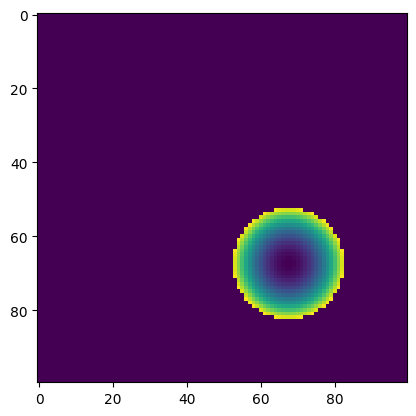

In [64]:
func_name = 4
mu = mu_func_array()
plt.imshow(mu)
plt.show()